# Varun Satish - ASTR 503 Midterm

In [1]:
# I'm not telling you what to import this time - it's an exam! 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from IPython.display import Image
from astropy.wcs import WCS
import trilogy
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt
plt.xkcd()

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations, and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

In [ ]:

fs = 1000
t = np.arange(0, 1, 1/fs)

signal55 = np.sin(2 * np.pi * 5.5 * t)
dirty60 = np.sin(2 * np.pi * 60 * t) + np.random.normal(0, 0.25, len(t))
white = np.random.normal(0, 1, len(t))
brownian = np.cumsum(np.random.normal(0, 1, len(t)))
f_noise = np.zeros(fs)
f_noise[0] = np.random.rand()
for i in range(1, fs):
    f_noise[i] = (f_noise[i-1] + f_noise[i-1]**2) % 1 
total_signal = signal55 + dirty60 + white + brownian + f_noise

signals = {
    '5.5 Hz Signal': signal55,
    '60 Hz Dirty Signal': dirty60,
    'White Noise': white,
    'Brownian Noise': brownian,
    '1/F Noise': f_noise,
}

plt.figure(figsize=(15, 10),dpi=200)
for i, (name, signal) in enumerate(signals.items()):
    plt.subplot(3, 2, i + 1)
    plt.plot(t, signal)
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
plt.subplot(3, 2, 6)
plt.plot(t, total_signal)
plt.title('Total Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.savefig('signals.png')
plt.close()

signal55 = np.bartlett(len(signal55)) * signal55
def power(x, a, b):
    return a * np.power(x, b)

def plot_psd(key,signal,i):
    N = len(signal)
    ft = np.fft.fft(signal)[:N//2]
    freq = np.fft.fftfreq(len(signal), 1/fs)[:N//2]
    psd = 2/N * np.abs(ft)
    plt.subplot(3,2,i)
    plt.loglog(freq, psd)
    plt.title(key)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    popt,pcov = curve_fit(power,freq[1:],psd[1:])
    return popt,pcov

popt_list = {}
plt.figure(figsize=(15, 10),dpi=200)
for i,key in enumerate(signals.keys()):
    popt,pcov = plot_psd(key,signals[key],i+1)
    popt_list[key] = popt
plt.tight_layout()
plt.savefig('psd.png')
plt.close()

def butter_fil(signal, cut, fs, btype, order=5): #what is a butter filter, but i will gladly accept it
    nyq = 0.5 * fs
    norm_cut = cut / nyq
    b, a = butter(order, norm_cut, btype=btype)
    y = filtfilt(b, a, signal) #filtfilt funny name
    return y

high_pass_signal = butter_fil(total_signal, 10, fs, 'high')
low_pass_signal = butter_fil(total_signal, 10, fs, 'low')
plt.figure(figsize=(15, 10))
high_popt, high_pcov = plot_psd('High Pass Filtered Signal', high_pass_signal,1)
low_popt, low_pcov = plot_psd('Low Pass Filtered Signal', low_pass_signal,2)
plt.tight_layout()
plt.savefig('filtered.png')
plt.close()

Signals for all the generated streams


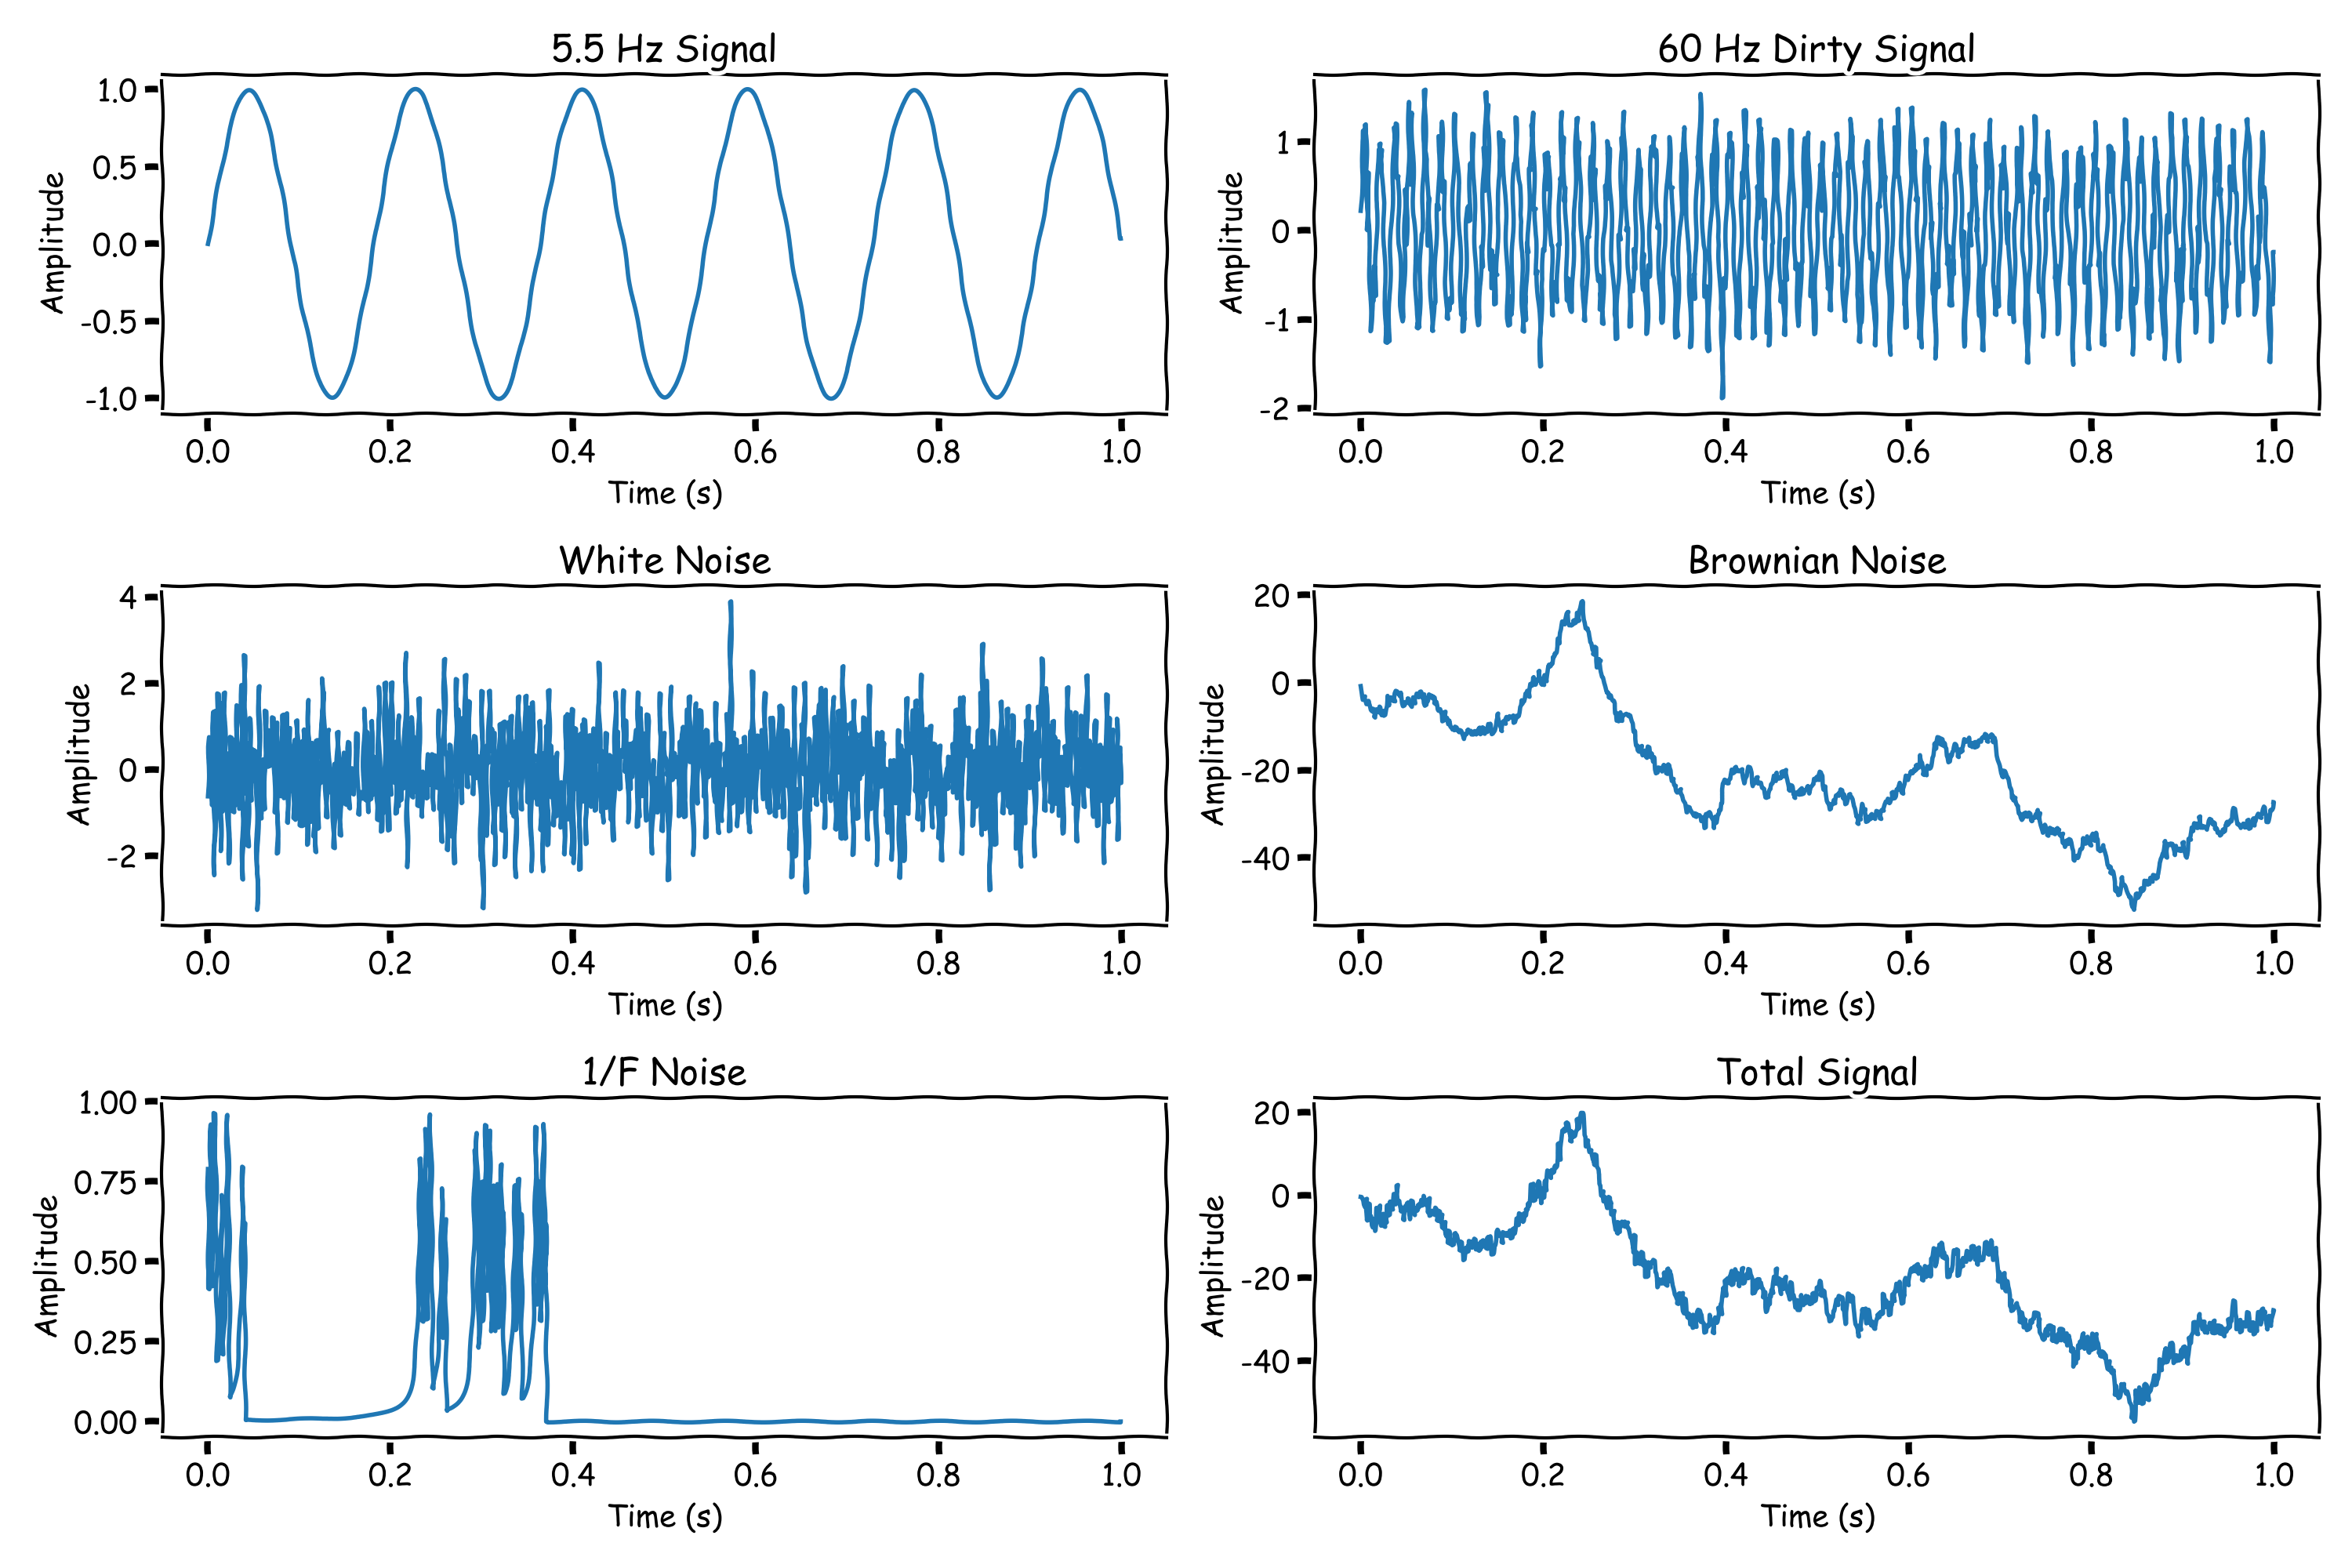

In [3]:
print('Signals for all the generated streams')
Image('signals.png')

In [4]:
for name, signal in signals.items():
    print(f'{name}: STD = {np.std(signal):.2f}, Num Above/Below 3 sigma = {np.sum(np.abs(signal) > 3 * np.std(signal))}')

5.5 Hz Signal: STD = 0.70, Num Above/Below 3 sigma = 0
60 Hz Dirty Signal: STD = 0.74, Num Above/Below 3 sigma = 0
White Noise: STD = 1.00, Num Above/Below 3 sigma = 3
Brownian Noise: STD = 14.38, Num Above/Below 3 sigma = 52
1/F Noise: STD = 0.19, Num Above/Below 3 sigma = 52


Power Spectral Density for all the generated streams


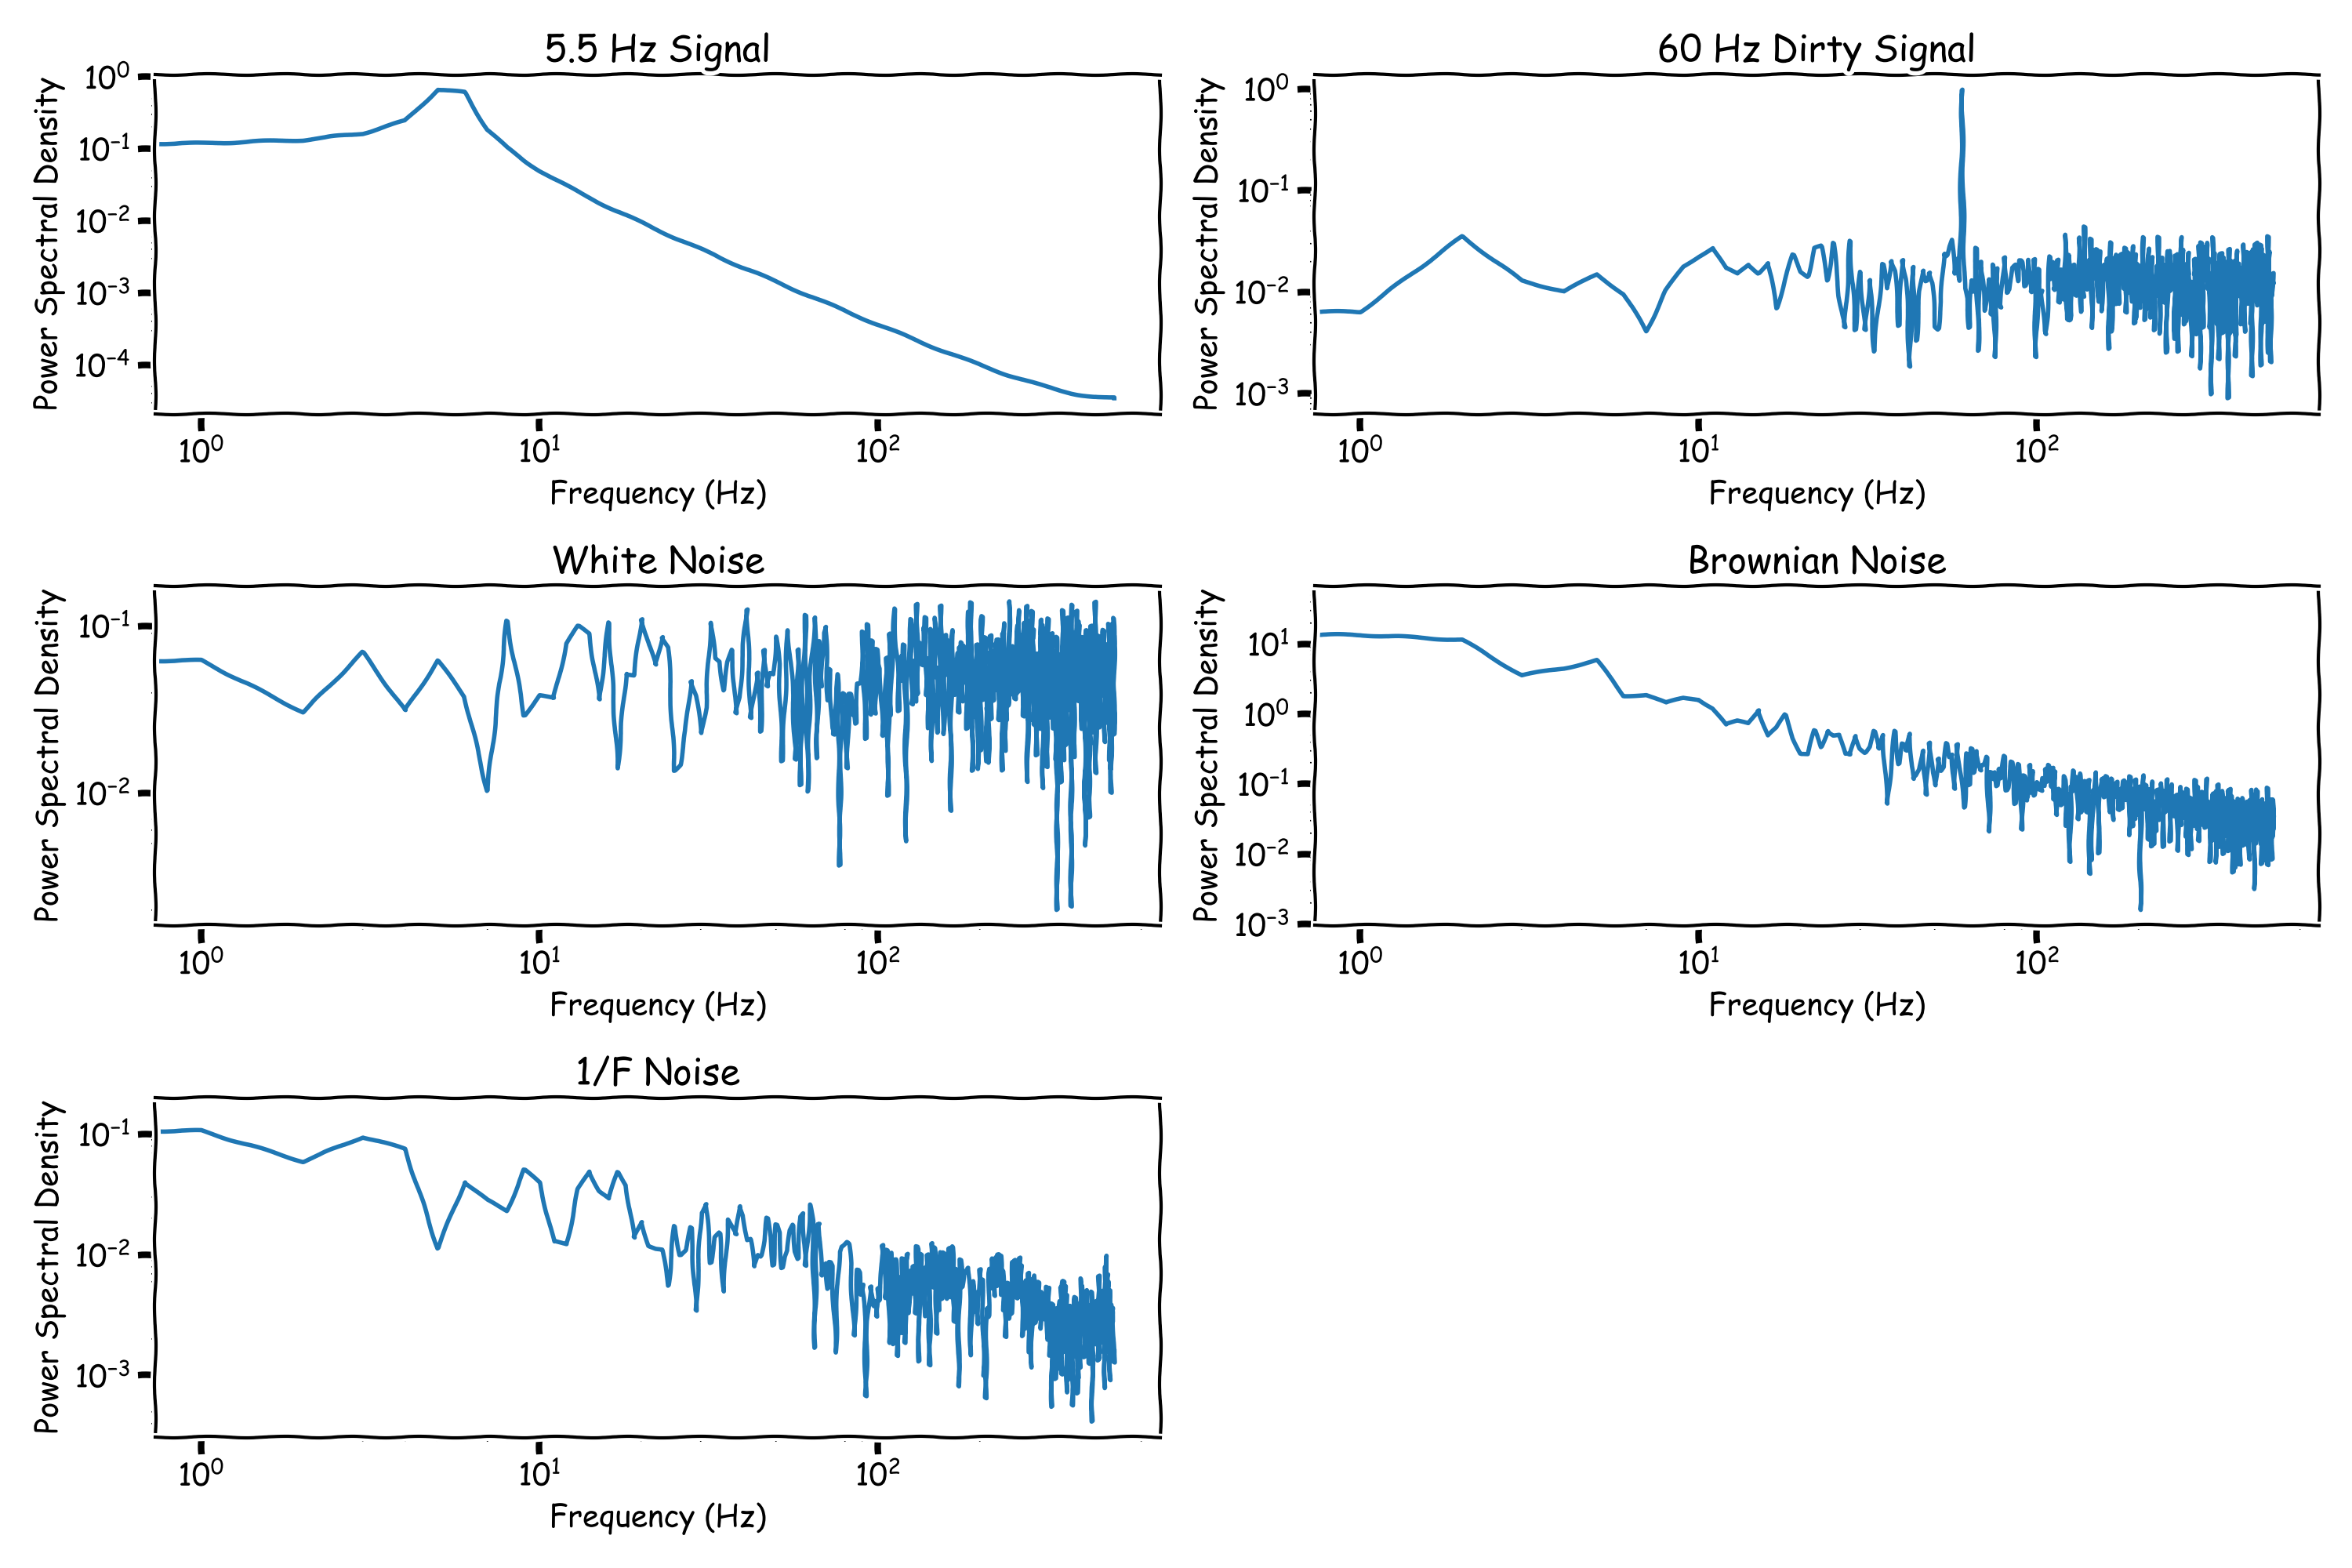

In [5]:
print('Power Spectral Density for all the generated streams')
Image('psd.png')

In [6]:
for i,key in enumerate(popt_list.keys()):
    print(f'{key}: alpha = {popt_list[key][1]:.5f}')

5.5 Hz Signal: alpha = -0.72590
60 Hz Dirty Signal: alpha = -0.11702
White Noise: alpha = 0.02426
Brownian Noise: alpha = -0.98358
1/F Noise: alpha = -0.57346


High and Low Pass Filtered Signals


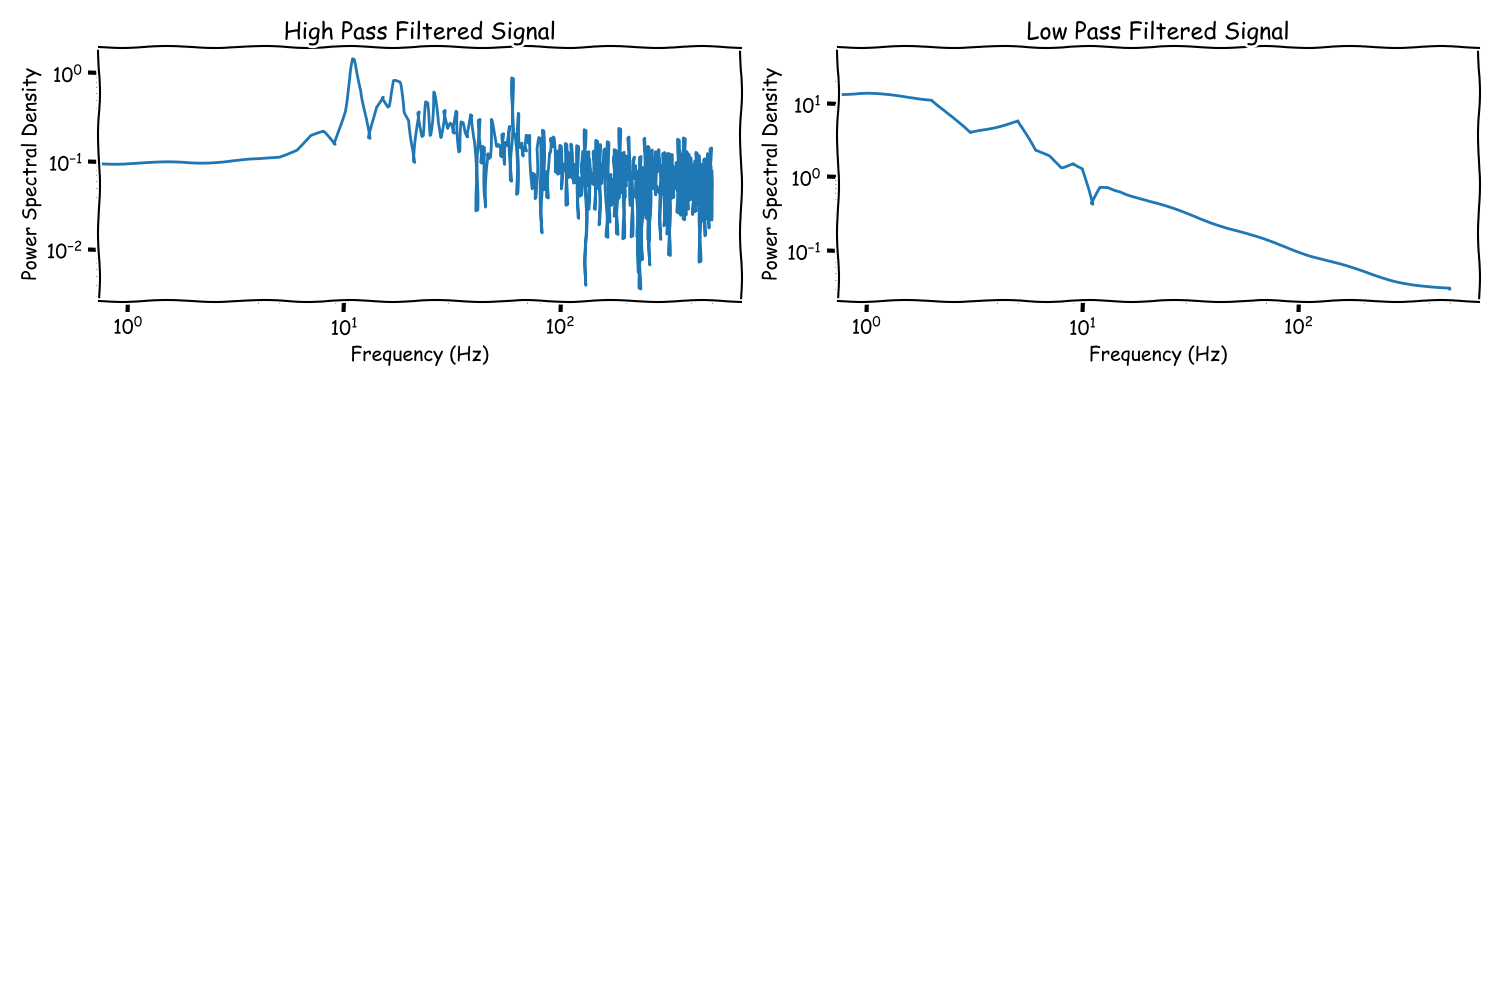

In [7]:
print('High and Low Pass Filtered Signals')
Image('filtered.png')

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [8]:
ALMA_870 = fits.open('data/SPT0538-50_ALMA_870um.fits')
SPT_220 = fits.open('data/SPT0538-50_SPT_220GHz.fits')
ALMA_data = ALMA_870[0].data[0,0]
SPT_data = SPT_220[0].data

In [9]:
ALMA_std = np.nanstd(ALMA_data)
print(f'STD of ALMA 870um: {ALMA_std}')

STD of ALMA 870um: 0.001384946284815669


In [10]:
SPT_std = np.nanstd(SPT_data)
print(f'STD of SPT 220GHz: {SPT_std}')

STD of SPT 220GHz: 7.949266728246585e-05


In [11]:
max_SNR_ALMA = np.nanmax(ALMA_data)/ALMA_std
print(f'Maximum SNR of ALMA 870um: {max_SNR_ALMA}')

Maximum SNR of ALMA 870um: 18.993730545043945


In [12]:
max_SNR_SPT = np.nanmax(SPT_data)/SPT_std
print(f'Maximum SNR of SPT 220GHz: {max_SNR_SPT}')

Maximum SNR of SPT 220GHz: 8.572112083435059


In [13]:
imagesRGB = {
    'G': ['data/DESJ053816.9-503050.8_r.fits'],
    'B': ['data/DESJ053816.9-503050.8_g.fits'],
    'R': ['data/DESJ053816.9-503050.8_i.fits']
}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
trilogy.Trilogy( #I don't know what this does but it looks cool, but also thank god for tutorials
    infile=None,
    samplesize=20000,
    stampsize=20000,
    maxstampsize=20000,
    deletetests=1,
    deletefilters=1,
    testfirst=0,
    showwith="PIL",
    mode='RGB',
    imagesorder='RGB',
    imagesRGB=imagesRGB,
    noiselums=noiselums,
    images=None,
    outname='DES RGB Image',
    satpercent=0.0009,
    noiselum=0.5,
    noisesig=50,
    noisesig0=10,
    correctbias=0,
    colorsatfac=1,
    combine='sum',
    show=True
).run()

From input file None :
From input parameters:
samplesize = 20000
stampsize = 20000
maxstampsize = 20000
deletetests = 1
deletefilters = 1
testfirst = 0
showwith = PIL
mode = RGB
imagesRGB = {'G': ['data/DESJ053816.9-503050.8_r.fits'], 'B': ['data/DESJ053816.9-503050.8_g.fits'], 'R': ['data/DESJ053816.9-503050.8_i.fits']}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
outname = DES RGB Image
satpercent = 0.0009
noiselum = 0.5
noisesig = 50
noisesig0 = 10
correctbias = 0
colorsatfac = 1
combine = sum
show = True
invert = False
Default:
indir =  (default)
outdir =  (default)
thumbnail = None (default)
sampledx = 0 (default)
sampledy = 0 (default)
showstamps = 0 (default)
scaling = None (default)
legend = 0 (default)
noise = None (default)
saturate = None (default)
bscale = 1 (default)
bzero = 0 (default)
Loading image data.
If multiple filters per channel, adding data.
B
data/DESJ053816.9-503050.8_g.fits[0] (1140, 1113) g
B = g

G
data/DESJ053816.9-503050.8_r.fits[0] (1140, 1113) r
G = r

R
d

DES RGB Image created


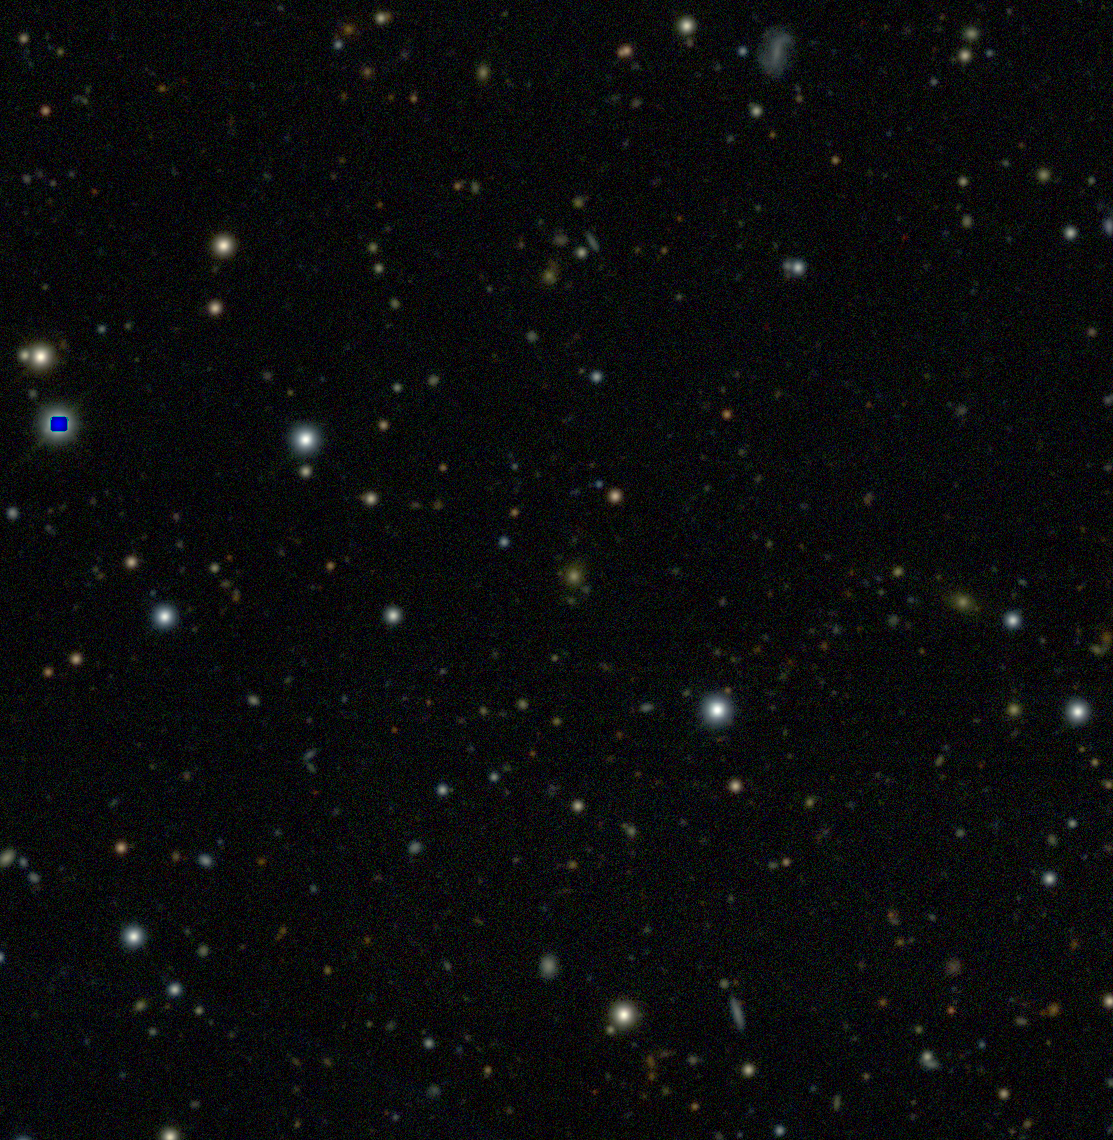

In [14]:
print(f'DES RGB Image created')
Image(filename='DES RGB Image.png',width=500,height=500) #DES RBG Image
# Tried doing this with trilogy but i forgot how wcs works so i gave up
# like in theory i could do it, but i'm too lazy to figure out how to do it. maybe if i have time after i finish the rest of the exam

In [15]:
alma_contour = np.array([5,10,15,20]) * ALMA_std
spt_contour = np.array([3,5,7,9]) * SPT_std
alma_contour, spt_contour, ALMA_std, SPT_std

(array([0.00692473, 0.01384946, 0.02077419, 0.02769893]),
 array([0.00023848, 0.00039746, 0.00055645, 0.00071543]),
 0.0013849463,
 7.949267e-05)

In [ ]:
alma_wcs = WCS(ALMA_870[0].header)[0,0]
spt_wcs = WCS(SPT_220[0].header)
fig = plt.figure(figsize=(15,10),dpi=200)
almaax = fig.add_subplot(121,projection=alma_wcs)
almaax.imshow(ALMA_870[0].data[0,0], origin='lower',cmap='inferno')
almaax.set_xlabel('RA')
almaax.set_ylabel('DEC')
almaax.set_title('ALMA 870um')
almaax.contour(ALMA_870[0].data[0,0], levels=alma_contour, colors='white', alpha=0.5)

sptax = fig.add_subplot(122,projection=spt_wcs)
sptax.imshow(SPT_220[0].data, origin='lower',cmap='inferno')
sptax.set_xlabel('RA')
sptax.set_ylabel('DEC')
sptax.set_title('SPT 220GHz')
sptax.contour(SPT_220[0].data, levels=spt_contour, colors='white')
plt.tight_layout()
plt.savefig('contours over alma and spt maps.png')
plt.close()

Contour plot of ALMA and SPT maps


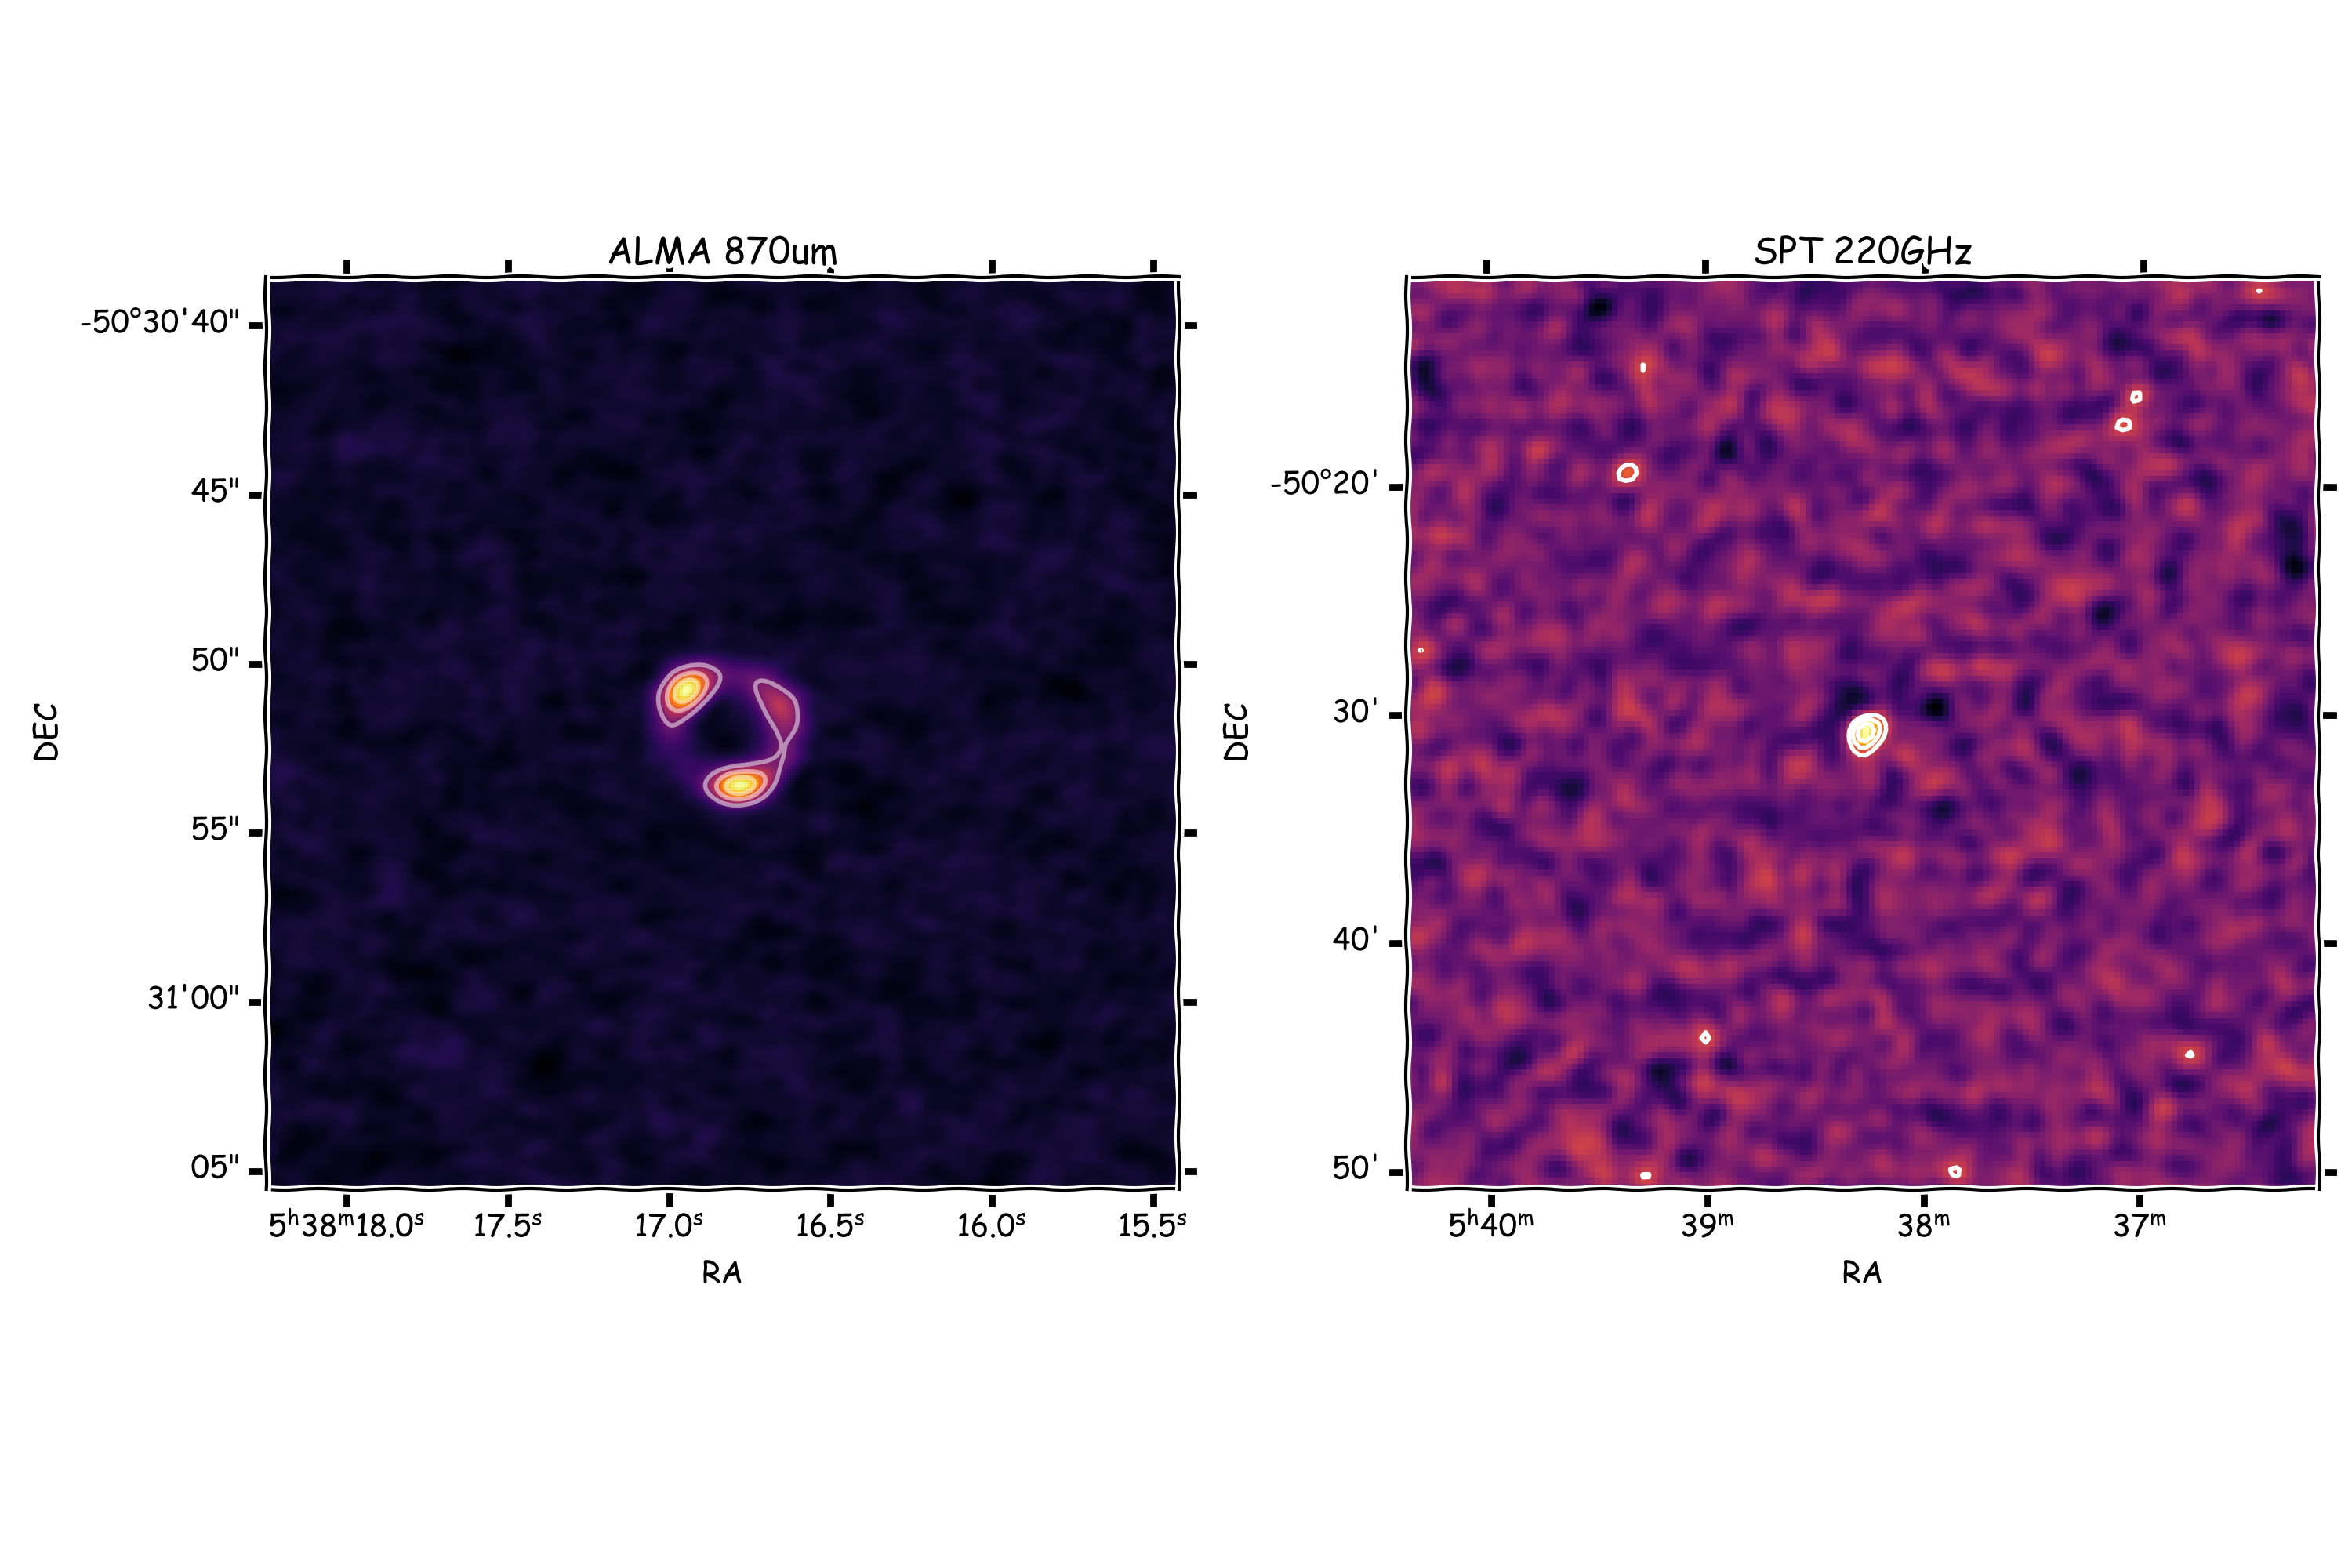

In [17]:
print('Contour plot of ALMA and SPT maps')
Image('contours over alma and spt maps.png')

Zoomed into Source with ALMA Contours


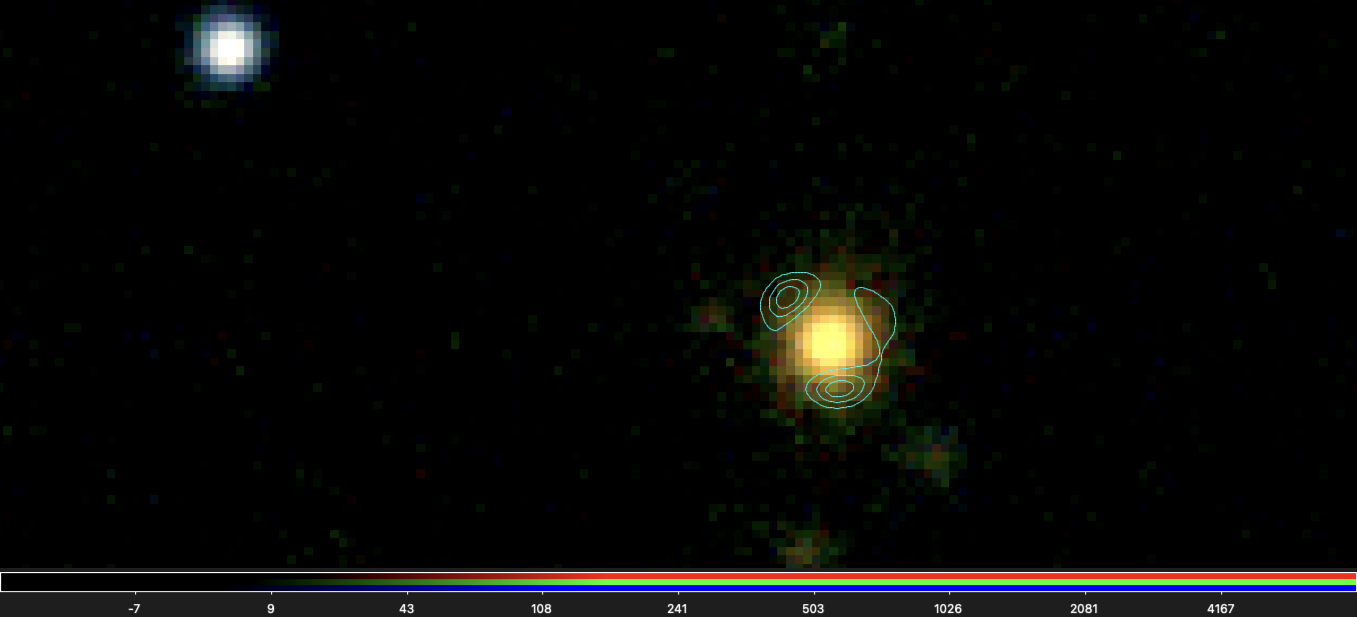

In [18]:
print('Zoomed into Source with ALMA Contours') #So i did this with DS9 instead. but i despise ds9. so here's a picture of it
Image('ds9-1.png')

Overplot with SPT contours


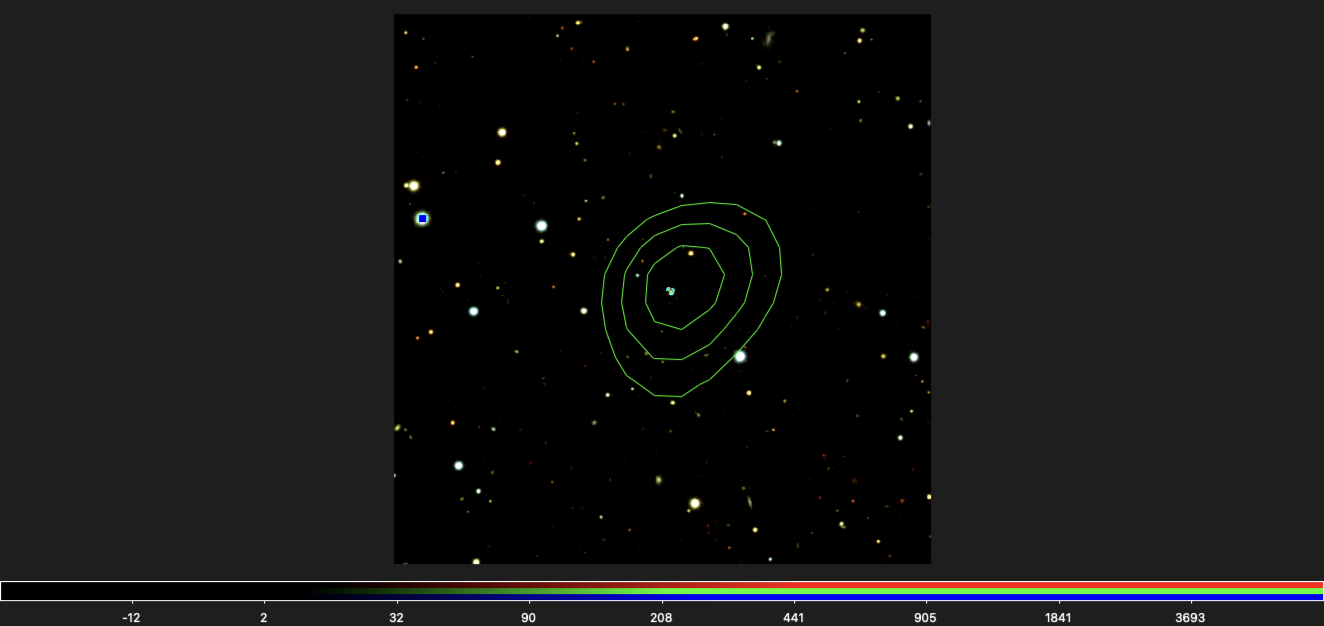

In [19]:
print('Overplot with SPT contours') #I did this with DS9 too. I'm sorry. I'm just too lazy to figure out how to do it with wcs
Image('ds9.png')

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [20]:
Vega = SkyCoord('18h36m56s +38d47m01s', frame='icrs')
print(f'a) RA in deg: {Vega.ra.deg}, Declination in Deg: {Vega.dec.deg}')
Vega_gal = Vega.galactic
print(f'b) Galactic Longitude: {Vega_gal.l}, Galactic Latitude: {Vega_gal.b}')

a) RA in deg: 279.2333333333333, Declination in Deg: 38.78361111111111
b) Galactic Longitude: 67.44773817064588 deg, Galactic Latitude: 19.238253586512474 deg


In [21]:
#UIObservatory = EarthLocation(lat=40.112, lon=-88.221)

In [22]:
def calc_riseset(targetra,targetdec,obsloc=(40.112, -88.221)):
    def dst_check(date : datetime, checkyear : int = 2024, dst_start : tuple = (3,10), dst_end : tuple = (11,3)):
        start = datetime(checkyear, dst_start[0], dst_start[1])
        end = datetime(checkyear, dst_end[0], dst_end[1])
        return start <= date < end
    datelist = [datetime(2024,1,1) + timedelta(days=i) for i in range(366)]
    target = SkyCoord(ra=targetra, dec=targetdec, frame='icrs')
    obslat = obsloc[0]
    obslon = obsloc[1]
    univtime = target.ra.deg/15 - [6.697374558 + (0.06570982441908*i) for i in range(366)] - obslon/15
    H = np.rad2deg(np.arccos(-np.tan(obslat*np.pi/180)*np.tan(target.dec.deg*np.pi/180))) / 15
    riset = np.zeros(366)
    sett = np.zeros(366)
    for i in range(366):
        if dst_check(datelist[i]):
            dst = -5
        else:
            dst = -6
        riset[i] = (24 + univtime[i] - H + dst) % 24
        sett[i] = (univtime[i] + H + dst) % 24
    return datelist,riset,sett

In [ ]:
dates,risetime,settime = calc_riseset('18h36m56s','+38d47m01s')
plt.figure(figsize=(15,5))
plt.plot(dates,risetime, label='rise')
plt.plot(dates,settime, label='set')
plt.ylim(0,24)
plt.ylabel('Central Time (Hours)')
plt.xlabel('Date')
plt.title('Rise/Set Times for Vega')
plt.legend()
plt.savefig('vega_riseset.png')
plt.tight_layout()
plt.close()

Plot of Rise/Set Times for Vega


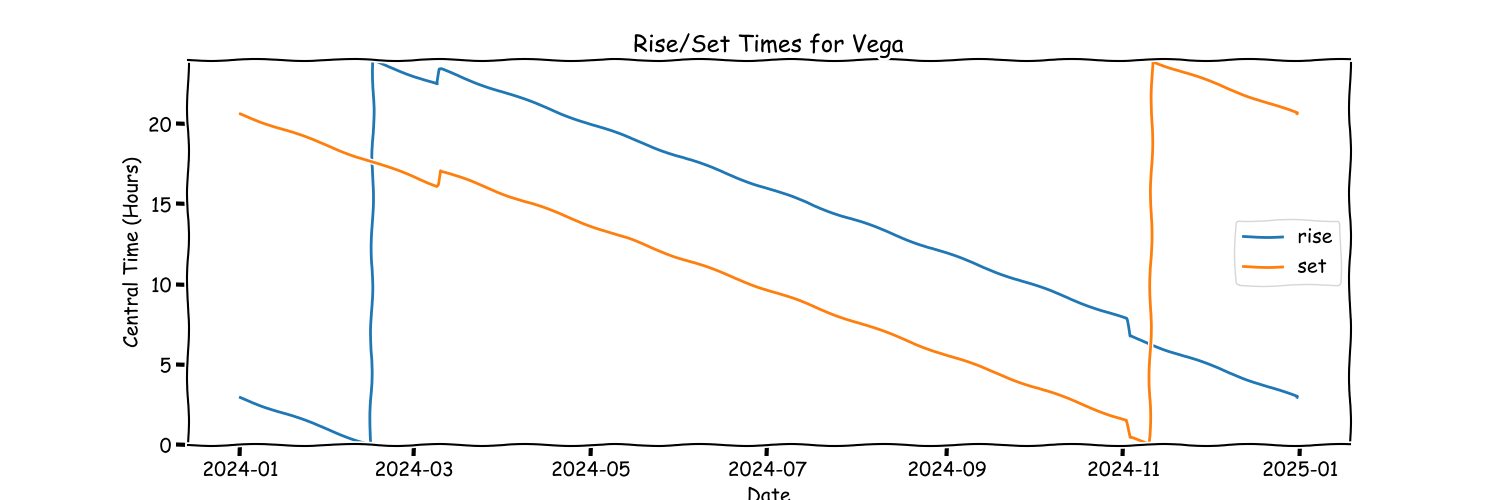

In [28]:
print('Plot of Rise/Set Times for Vega')
Image('vega_riseset.png')

[Height of Observatory source](https://web.astronomicalheritage.net/show-entity?identity=79&idsubentity=1#:~:text=Latitude%2040%C2%B0%206%E2%80%B2%2018.9,elevation%20227m%20(744%20ft).W)

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!